In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

import cv2
import h5py

2023-07-26 01:54:04.122703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with h5py.File("data/processed_data.h5", "r") as f:
    imgs_train, labels_train = np.array(f["X_train"]), np.array(f["y_train"])
    imgs_test, labels_test = np.array(f["X_test"]), np.array(f["y_test"])

imgs_train2 = []
for img in imgs_train:
    new_img = cv2.resize(img, (128,128))
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    imgs_train2.append(new_img)
for img in imgs_test:
    new_img = cv2.resize(img, (128,128))
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    imgs_train2.append(new_img)
imgs_train = np.array(imgs_train2)[:, :, :, np.newaxis] / 255
labels_train = np.vstack((labels_train,labels_test))

In [3]:
shape_img = imgs_train.shape[1:]
n_cat = labels_train.shape[1]
latent_dim = 256

In [4]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    activation = LeakyReLU(0.3),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x

def conv_block_transpose(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    activation = LeakyReLU(0.3),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2DTranspose(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x

In [5]:
enc_input_image = Input(shape=(shape_img), name="input_image")
enc_input_label = Input(shape=(n_cat), name="input_label")

# convolutionals block
enc_conv = conv_block(enc_input_image, filters=64, use_bn=True) # 128x128x64
enc_conv = conv_block(enc_conv, filters=64, strides=(2,2), use_bn=True, use_dropout=True) # 64x64x64

enc_conv = conv_block(enc_conv, filters=128, use_bn=True) # 64x64x128
enc_conv = conv_block(enc_conv, filters=128, strides=(2,2), use_bn=True, use_dropout=True) # 32x32x128

enc_conv = conv_block(enc_conv, filters=256, use_bn=True) # 32x32x256
#enc_conv = conv_block(enc_conv, filters=256, use_bn=True, use_dropout=True) # 32x32x256
#enc_conv = conv_block(enc_conv, filters=256, use_bn=True) # 32x32x256
enc_conv = conv_block(enc_conv, filters=256, strides=(2,2), use_bn=True, use_dropout=True) # 16x16x256

enc_conv = conv_block(enc_conv, filters=512, use_bn=True) # 16x16x512
#enc_conv = conv_block(enc_conv, filters=512, use_bn=True, use_dropout=True) # 16x16x512
#enc_conv = conv_block(enc_conv, filters=512, use_bn=True) # 16x16x512
enc_conv = conv_block(enc_conv, filters=512, strides=(2,2), use_bn=True, use_dropout=True) # 8x8x512

enc_conv = conv_block(enc_conv, filters=512, use_bn=True) # 8x8x512
#enc_conv = conv_block(enc_conv, filters=512, use_bn=True, use_dropout=True) # 8x8x512
#enc_conv = conv_block(enc_conv, filters=512, use_bn=True) # 8x8x512
enc_conv = conv_block(enc_conv, filters=512, strides=(2,2), use_bn=True, use_dropout=True) # 4x4x512


# concat
flattened = Flatten()(enc_conv)
enc_concat = Concatenate()([flattened, enc_input_label])


enc_hidden = Dense(4096)(enc_concat)
#enc_hidden = Dropout(0.3)(enc_hidden)
#enc_hidden = Dense(4096)(enc_hidden)
enc_hidden = Dropout(0.3)(enc_hidden)
enc_hidden = Dense(1024)(enc_hidden)
z_mean = Dense(latent_dim, activation='linear', name="mu")(enc_hidden)
z_log_var = Dense(latent_dim, activation='linear', name="l_sigma")(enc_hidden)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([enc_input_image, enc_input_label], [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_image[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     multiple                     0         ['batch_normalization[0]

 input_label (InputLayer)    [(None, 4)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 8196)                 0         ['flatten[0][0]',             
                                                                     'input_label[0][0]']         
                                                                                                  
 dense (Dense)               (None, 4096)                 3357491   ['concatenate[0][0]']         
                                                          2                                       
                                                                                                  
 dropout_5 (Dropout)         (None, 4096)                 0         ['dense[0][0]']               
                                                                                                  
 dense_1 (

2023-07-26 01:54:06.952052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 01:54:06.954905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 01:54:06.955041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
dec_inp_latent_vector = Input(shape=(latent_dim), name="input_latent_vector")
decoder_inp_label = Input(shape=(n_cat), name = "input_label")
dec_concat = Concatenate(name="decoder_concat")([dec_inp_latent_vector, decoder_inp_label])

dec_hidden = Dense(1024, activation="relu")(dec_concat)
dec_hidden = Dropout(0.3)(dec_hidden)
#dec_hidden = Dense(4096, activation="relu")(dec_hidden)
#dec_hidden = Dropout(0.3)(dec_hidden)
dec_hidden = Dense(4096, activation="relu")(dec_hidden)
dec_hidden = Dense(4*4*512, activation="relu", name="hidden_layer7")(dec_hidden)
dec_hidden = Dropout(0.3)(dec_hidden)
reshaped = Reshape(target_shape=(4,4,512))(dec_hidden)

dec_conv = conv_block_transpose(reshaped, filters=512, use_bn=True, use_dropout=True)  # 4x4x512
#dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True)  # 4x4x512
#dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True, use_dropout=True)  # 4x4x512
dec_conv = conv_block_transpose(dec_conv, filters=512, strides=(2,2), use_bn=True)  # 8x8x512

dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True)  # 8x8x512
#dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True, use_dropout=True)  # 8x8x512
#dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True)  # 8x8x512
dec_conv = conv_block_transpose(dec_conv, filters=512, strides=(2,2), use_bn=True, use_dropout=True)  # 16x16x512

dec_conv = conv_block_transpose(dec_conv, filters=256, use_bn=True)  # 16x16x256
#dec_conv = conv_block_transpose(dec_conv, filters=256, use_bn=True, use_dropout=True)  # 16x16x256
#dec_conv = conv_block_transpose(dec_conv, filters=256, use_bn=True)  # 16x16x256
dec_conv = conv_block_transpose(dec_conv, filters=256, strides=(2,2), use_bn=True, use_dropout=True)  # 32x32x256

dec_conv = conv_block_transpose(dec_conv, filters=128, use_bn=True, use_dropout=True)  # 32x32x128
dec_conv = conv_block_transpose(dec_conv, filters=128, strides=(2,2), use_bn=True)  # 64x64x128

dec_conv = conv_block_transpose(dec_conv, filters=64, use_bn=True, use_dropout=True)  # 64x64x64
dec_conv = conv_block_transpose(dec_conv, filters=128, strides=(2,2), use_bn=True)  # 128x128x64

dec_output_img = Conv2DTranspose(filters=1, kernel_size=3, padding="same", activation="sigmoid")(dec_conv)


decoder = keras.Model([dec_inp_latent_vector, decoder_inp_label], dec_output_img, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_latent_vector (Input  [(None, 256)]                0         []                            
 Layer)                                                                                           
                                                                                                  
 input_label (InputLayer)    [(None, 4)]                  0         []                            
                                                                                                  
 decoder_concat (Concatenat  (None, 260)                  0         ['input_latent_vector[0][0]', 
 e)                                                                  'input_label[0][0]']         
                                                                                            

 tchNormalization)                                                                                
                                                                                                  
 dropout_10 (Dropout)        (None, 32, 32, 256)          0         ['leaky_re_lu_1[5][0]']       
                                                                                                  
 conv2d_transpose_6 (Conv2D  (None, 32, 32, 128)          295040    ['dropout_10[0][0]']          
 Transpose)                                                                                       
                                                                                                  
 batch_normalization_16 (Ba  (None, 32, 32, 128)          512       ['conv2d_transpose_6[0][0]']  
 tchNormalization)                                                                                
                                                                                                  
 dropout_1

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        imgs, labels = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([imgs, labels])
            reconstruction = self.decoder([z, labels])
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(imgs, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-4))

In [9]:
vae.fit([imgs_train, labels_train], epochs=400, batch_size=64)

Epoch 1/400


2023-07-26 01:54:15.714429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-26 01:54:16.436173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-26 01:54:18.114799: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd1f6972d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-26 01:54:18.114825: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-07-26 01:54:18.118429: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-26 01:54:18.188224: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

51/51 [==============================] - 18s 128ms/step - loss: 9543.1823 - reconstruction_loss: 8353.4805 - kl_loss: 2.4968
Epoch 2/400
51/51 [==============================] - 7s 128ms/step - loss: 6966.4034 - reconstruction_loss: 6862.8369 - kl_loss: 20.8391
Epoch 3/400
51/51 [==============================] - 7s 129ms/step - loss: 6840.3314 - reconstruction_loss: 6806.8975 - kl_loss: 15.3684
Epoch 4/400
51/51 [==============================] - 7s 130ms/step - loss: 6827.0134 - reconstruction_loss: 6790.9448 - kl_loss: 14.1169
Epoch 5/400
51/51 [==============================] - 7s 130ms/step - loss: 6763.2988 - reconstruction_loss: 6771.4443 - kl_loss: 15.4294
Epoch 6/400
51/51 [==============================] - 7s 130ms/step - loss: 6725.7483 - reconstruction_loss: 6722.3120 - kl_loss: 20.7207
Epoch 7/400
51/51 [==============================] - 7s 131ms/step - loss: 6656.7728 - reconstruction_loss: 6684.4849 - kl_loss: 23.4588
Epoch 8/400
51/51 [==============================] - 

51/51 [==============================] - 6s 125ms/step - loss: 6278.4510 - reconstruction_loss: 6193.3926 - kl_loss: 47.4163
Epoch 61/400
51/51 [==============================] - 6s 125ms/step - loss: 6201.8473 - reconstruction_loss: 6187.1318 - kl_loss: 47.4893
Epoch 62/400
51/51 [==============================] - 6s 125ms/step - loss: 6251.4245 - reconstruction_loss: 6178.8237 - kl_loss: 47.4085
Epoch 63/400
51/51 [==============================] - 6s 125ms/step - loss: 6279.3647 - reconstruction_loss: 6176.5103 - kl_loss: 47.4141
Epoch 64/400
51/51 [==============================] - 6s 125ms/step - loss: 6213.0725 - reconstruction_loss: 6174.0669 - kl_loss: 47.2225
Epoch 65/400
51/51 [==============================] - 6s 125ms/step - loss: 6227.7868 - reconstruction_loss: 6171.1890 - kl_loss: 47.0729
Epoch 66/400
51/51 [==============================] - 6s 125ms/step - loss: 6121.4142 - reconstruction_loss: 6170.1660 - kl_loss: 47.2026
Epoch 67/400
51/51 [===========================

51/51 [==============================] - 6s 127ms/step - loss: 6080.1151 - reconstruction_loss: 6047.9126 - kl_loss: 43.3832
Epoch 120/400
51/51 [==============================] - 7s 128ms/step - loss: 6036.5437 - reconstruction_loss: 6047.5723 - kl_loss: 43.0703
Epoch 121/400
51/51 [==============================] - 6s 127ms/step - loss: 6087.2654 - reconstruction_loss: 6046.1807 - kl_loss: 43.0127
Epoch 122/400
51/51 [==============================] - 7s 133ms/step - loss: 6115.0309 - reconstruction_loss: 6047.0376 - kl_loss: 42.9571
Epoch 123/400
51/51 [==============================] - 7s 132ms/step - loss: 6078.2894 - reconstruction_loss: 6042.7075 - kl_loss: 43.0469
Epoch 124/400
51/51 [==============================] - 7s 129ms/step - loss: 6117.3194 - reconstruction_loss: 6042.0664 - kl_loss: 43.0149
Epoch 125/400
51/51 [==============================] - 6s 127ms/step - loss: 6057.4173 - reconstruction_loss: 6041.7148 - kl_loss: 42.5810
Epoch 126/400
51/51 [====================

51/51 [==============================] - 6s 127ms/step - loss: 6015.3235 - reconstruction_loss: 5968.6470 - kl_loss: 39.3313
Epoch 179/400
51/51 [==============================] - 7s 128ms/step - loss: 5981.3924 - reconstruction_loss: 5965.9390 - kl_loss: 38.8810
Epoch 180/400
51/51 [==============================] - 7s 130ms/step - loss: 5978.0974 - reconstruction_loss: 5967.1763 - kl_loss: 39.1938
Epoch 181/400
51/51 [==============================] - 7s 134ms/step - loss: 5993.9321 - reconstruction_loss: 5962.5293 - kl_loss: 38.9210
Epoch 182/400
51/51 [==============================] - 7s 133ms/step - loss: 5972.8605 - reconstruction_loss: 5961.9414 - kl_loss: 38.9316
Epoch 183/400
51/51 [==============================] - 7s 132ms/step - loss: 5995.8534 - reconstruction_loss: 5963.5293 - kl_loss: 38.7168
Epoch 184/400
51/51 [==============================] - 7s 132ms/step - loss: 5948.5378 - reconstruction_loss: 5962.2388 - kl_loss: 38.8255
Epoch 185/400
51/51 [====================

51/51 [==============================] - 7s 130ms/step - loss: 5947.5940 - reconstruction_loss: 5920.0127 - kl_loss: 36.2422
Epoch 238/400
51/51 [==============================] - 6s 127ms/step - loss: 5975.4717 - reconstruction_loss: 5920.7734 - kl_loss: 36.1896
Epoch 239/400
51/51 [==============================] - 6s 127ms/step - loss: 5926.7536 - reconstruction_loss: 5919.0864 - kl_loss: 36.1700
Epoch 240/400
51/51 [==============================] - 6s 127ms/step - loss: 5931.5197 - reconstruction_loss: 5918.7139 - kl_loss: 36.1082
Epoch 241/400
51/51 [==============================] - 6s 127ms/step - loss: 5991.6167 - reconstruction_loss: 5921.5176 - kl_loss: 36.0889
Epoch 242/400
51/51 [==============================] - 6s 127ms/step - loss: 5978.0596 - reconstruction_loss: 5917.2090 - kl_loss: 36.1162
Epoch 243/400
51/51 [==============================] - 6s 127ms/step - loss: 5938.7716 - reconstruction_loss: 5916.6895 - kl_loss: 36.1851
Epoch 244/400
51/51 [====================

51/51 [==============================] - 7s 130ms/step - loss: 5922.5043 - reconstruction_loss: 5891.9751 - kl_loss: 34.4311
Epoch 297/400
51/51 [==============================] - 7s 130ms/step - loss: 5934.4730 - reconstruction_loss: 5890.7139 - kl_loss: 34.3768
Epoch 298/400
51/51 [==============================] - 7s 130ms/step - loss: 5932.6475 - reconstruction_loss: 5890.0269 - kl_loss: 34.1958
Epoch 299/400
51/51 [==============================] - 7s 130ms/step - loss: 5932.9945 - reconstruction_loss: 5890.9424 - kl_loss: 34.1704
Epoch 300/400
51/51 [==============================] - 7s 130ms/step - loss: 5894.8094 - reconstruction_loss: 5889.7075 - kl_loss: 34.2380
Epoch 301/400
51/51 [==============================] - 7s 130ms/step - loss: 5936.8171 - reconstruction_loss: 5888.6582 - kl_loss: 34.2087
Epoch 302/400
51/51 [==============================] - 7s 130ms/step - loss: 5948.3025 - reconstruction_loss: 5888.4312 - kl_loss: 34.1957
Epoch 303/400
51/51 [====================

51/51 [==============================] - 7s 131ms/step - loss: 5905.9601 - reconstruction_loss: 5872.7100 - kl_loss: 32.8724
Epoch 356/400
51/51 [==============================] - 7s 132ms/step - loss: 5908.8498 - reconstruction_loss: 5873.6328 - kl_loss: 32.9398
Epoch 357/400
51/51 [==============================] - 7s 130ms/step - loss: 5888.7099 - reconstruction_loss: 5872.3862 - kl_loss: 32.7977
Epoch 358/400
51/51 [==============================] - 7s 129ms/step - loss: 5914.3435 - reconstruction_loss: 5872.0171 - kl_loss: 32.9763
Epoch 359/400
51/51 [==============================] - 7s 129ms/step - loss: 5917.0906 - reconstruction_loss: 5870.2515 - kl_loss: 32.7463
Epoch 360/400
51/51 [==============================] - 7s 128ms/step - loss: 5925.2719 - reconstruction_loss: 5870.7227 - kl_loss: 32.6762
Epoch 361/400
51/51 [==============================] - 7s 129ms/step - loss: 5915.0979 - reconstruction_loss: 5871.0171 - kl_loss: 32.5893
Epoch 362/400
51/51 [====================

In [88]:
_, _, z = vae.encoder.predict([imgs_train[10:11], labels_train[10:11]])

1/1 [==============================] - 0s 15ms/step


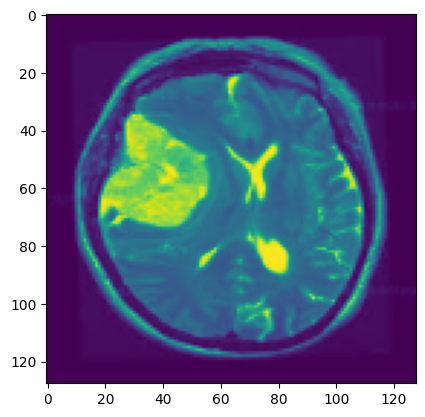

In [76]:
plt.imshow(imgs_train[10:11][0])

1/1 [==============================] - 0s 10ms/step


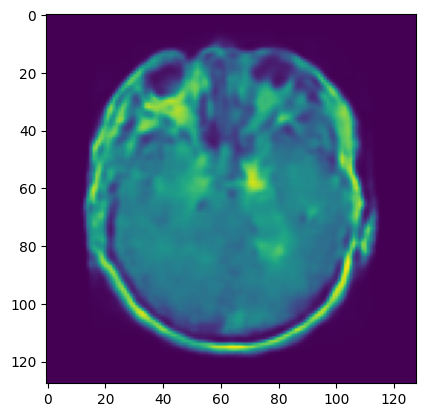

In [82]:
import matplotlib.pyplot as plt
plt.imshow(vae.decoder.predict([z, labels_train[10:11]]).reshape(128,128))

1/1 [==============================] - 0s 15ms/step


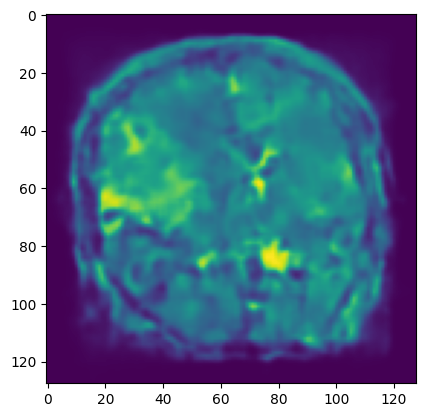

In [91]:
import matplotlib.pyplot as plt
plt.imshow(vae.decoder.predict([z, labels_train[0:1]]).reshape(128,128))

In [17]:
z.min()

-2.6887162

In [90]:
z = z + np.random.uniform(-1.25,1.25, size=z.shape)

In [31]:
z.max()

4.21611467635101

In [1]:
plt.imshow(imgs_train[0])

NameError: name 'plt' is not defined

In [84]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    print(grid_x)
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "decoder" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 2) dtype=float32>]


In [87]:
z = np.linspace(-1, 1, 256)



array([-0.53655295, -0.52870981, -0.52086667, -0.51302353, -0.5051804 ,
       -0.49733726, -0.48949412, -0.48165099, -0.47380785, -0.46596471,
       -0.45812157, -0.45027844, -0.4424353 , -0.43459216, -0.42674902,
       -0.41890589, -0.41106275, -0.40321961, -0.39537648, -0.38753334,
       -0.3796902 , -0.37184706, -0.36400393, -0.35616079, -0.34831765,
       -0.34047451, -0.33263138, -0.32478824, -0.3169451 , -0.30910197,
       -0.30125883, -0.29341569, -0.28557255, -0.27772942, -0.26988628,
       -0.26204314, -0.2542    , -0.24635687, -0.23851373, -0.23067059,
       -0.22282746, -0.21498432, -0.20714118, -0.19929804, -0.19145491,
       -0.18361177, -0.17576863, -0.16792549, -0.16008236, -0.15223922,
       -0.14439608, -0.13655295, -0.12870981, -0.12086667, -0.11302353,
       -0.1051804 , -0.09733726, -0.08949412, -0.08165099, -0.07380785,
       -0.06596471, -0.05812157, -0.05027844, -0.0424353 , -0.03459216,
       -0.02674902, -0.01890589, -0.01106275, -0.00321961,  0.00